# Deep $Q$-learning

In this notebook, I'll build a neural network that can learn to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](cart-pole.jpg)

In [1]:
import gym
import numpy as np

# Create the Cart-Pole game environment
env = gym.make('CartPole-v1')

# environment details
print('Number of possible actions:', env.action_space.n)
print('States:', env.observation_space)
print(env.observation_space.low)
print(env.observation_space.high)

Number of possible actions: 2
States: Box(4,)
[-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38]
[4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38]


In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

In [2]:
from time import sleep


actions = [] # actions that the agent selects
rewards = [] # obtained rewards
state = env.reset()

while True:
    action = env.action_space.sample()  # choose a random action
    state, reward, done, _ = env.step(action) 
    env.render()
    sleep(0.15)
    rewards.append(reward)
    actions.append(action)
    if done:
        env.close()
        break
        
print('Actions:', actions)
print('Rewards:', rewards)

Actions: [0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0]
Rewards: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


The game resets after the pole has fallen past a certain angle. For each step while the game is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. The network's goal is to maximize the reward by keeping the pole vertical.

## $Q$-Network

The neural network accepts a state $s$ as input and the output will be $Q$-values for each available action $a$.

For this Cart-Pole game, the state has four values: the position and velocity of the cart, and the position and velocity of the pole.  Thus, the neural network has **four inputs**, one for each value in the state, and **two outputs**, one for each possible action. 

Below is one implementation of the $Q$-network that uses 3 fully connected layers with ReLU activations.

In [3]:
import tensorflow as tf


def fully_connected(name, input_tensor, num_units, activation=tf.nn.relu):
    """Returns a fully connected layer"""
    # initialize weights
    w = tf.compat.v1.get_variable(f"W_{name}", shape=[input_tensor.get_shape()[1], num_units],
                                  initializer=tf.compat.v1.initializers.he_uniform(),
                                  dtype=tf.float32, trainable=True)
    # initialize bias
    b = tf.compat.v1.get_variable(f"B_{name}", shape=[num_units], 
                                  initializer=tf.constant_initializer(0.0), 
                                  dtype=tf.float32,
                                  trainable=True)
    # output
    out = tf.matmul(input_tensor, w) + b
    # add activation
    if activation:
        out = activation(out, name=f"activation_{name}")
    # change name
    out = tf.compat.v1.identity(out, name=name)

    return out
    

class QNetwork:
    def __init__(self, learning_rate=0.01, state_size=4, 
                 action_size=2, hidden_size=10, 
                 name='QNetwork'):
        with tf.variable_scope(name):
            # state inputs to the Q-network
            self.inputs_ = tf.placeholder(tf.float32, [None, state_size], name='inputs')
            
            # One hot encode the actions to later choose the Q-value for the action
            self.actions_ = tf.placeholder(tf.int32, [None], name='actions')
            one_hot_actions = tf.one_hot(self.actions_, action_size)
            
            # Target Q values for training
            self.targetQs_ = tf.placeholder(tf.float32, [None], name='target')
            
            # ReLU hidden layers
            self.fc1 = fully_connected("h1", self.inputs_, hidden_size)
            self.fc2 = fully_connected("h2", self.fc1, hidden_size)
            self.fc3 = fully_connected("h3", self.fc2, hidden_size)

            # Linear output layer
            self.output = fully_connected("output", self.fc3, action_size, activation=None)
            
            ### Train using mean squared error and Adam gradient descent.
            self.Q = tf.reduce_sum(tf.multiply(self.output, one_hot_actions), axis=1)
            self.loss = tf.reduce_mean(tf.square(self.targetQs_ - self.Q))
            self.opt = tf.train.AdamOptimizer(learning_rate).minimize(self.loss)

## Experience replay

To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

This `Memory` object will store model's experience $<state, action, reward, next state>$. 
This memory will have a maximum capacity, so we can keep newer experiences in memory while getting rid of older experiences. 
Then, we'll sample a random mini-batch of transitions $<state, action, reward, next state>$ and train on those.

In [4]:
from collections import deque

class Memory():
    def __init__(self, max_size=1000):
        self.buffer = deque(maxlen=max_size)
    
    def add(self, experience):
        self.buffer.append(experience)
            
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx]

## $Q$-Learning training algorithm

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode $\leftarrow 1$ **to** $M$ **do**
  * Observe $s_0$
  * **For** $t \leftarrow 0$ **to** $T-1$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s_t,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

## Hyperparameters

In [5]:
train_episodes = 700          # max number of episodes to learn from
max_steps = 500               # max steps in an episode
gamma = 1.0                   # future reward discount

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0002            # exponential decay rate for exploration prob

# Network parameters
hidden_size = 64               # number of units in each Q-network hidden layer
learning_rate = 0.0001         # Q-network learning rate

# Memory parameters
memory_size = 100000            # memory capacity
batch_size = 32                # experience mini-batch size
pretrain_length = batch_size   # number experiences to pretrain the memory

In [6]:
tf.reset_default_graph()
mainQN = QNetwork(name='main', hidden_size=hidden_size, learning_rate=learning_rate)

## Populate the experience memory

I re-initialize the simulation and pre-populate the memory in order to use later on the mini-batch.
To do this the agent will take random actions and storing the transitions in memory.
I also decided to modify the value of the reward in order to get a bigger reward if the cart stays centered.

In [7]:
# Initialize the environment
env.reset()
# Take one random step to get the pole and cart moving
state, reward, done, _ = env.step(env.action_space.sample())

memory = Memory(max_size=memory_size)

# Make a bunch of random actions and store the experiences
for ii in range(pretrain_length):

    # Make a random action
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    # reduce the reward if the cart is not centered
    reward = max(0, reward * (1 - abs(next_state[1]/2.4)))

    if done:
        # The simulation fails so no next state
        next_state = np.zeros(state.shape)
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        
        # Start new episode
        env.reset()
        # Take one random step to get the pole and cart moving
        state, reward, done, _ = env.step(env.action_space.sample())
    else:
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        state = next_state

## Training

Now it is time to train the agent.
The training will stop automatically after 700 episodes or after 10 consecutive very high scores.

In [8]:
saver = tf.train.Saver()
rewards_list = []
with tf.Session() as sess:
    # Initialize variables
    sess.run(tf.global_variables_initializer())
    
    step = 0
    for ep in range(1, train_episodes):
        total_reward = 0
        t = 0
        while t < max_steps:
            step += 1
            # Uncomment these next 2 lines to watch the training
            env.render() 
            sleep(0.0005)
            
            # Explore or Exploit
            explore_p = explore_stop + (explore_start - explore_stop)*np.exp(-decay_rate*step) 
            if explore_p > np.random.rand():
                # Make a random action
                action = env.action_space.sample()
            else:
                # Get action from Q-network
                feed = {mainQN.inputs_: state.reshape((1, *state.shape))}
                Qs = sess.run(mainQN.output, feed_dict=feed)
                action = np.argmax(Qs)
            
            # Take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
            # reduce the reward if the cart is not centered
            reward = max(0, reward * (1 - abs(next_state[1]/2.4)))
            if reward < 0 or reward > 1.0:
                print("Reward: ", reward)
                raise ValueError("reward is not in range")
            total_reward += reward
            
            if done:
                # the episode ends so no next state
                next_state = np.zeros(state.shape)
                t = max_steps
                
                print('Episode: {}'.format(ep),
                      'Total reward: {}'.format(total_reward),
                      'Explore P: {:.4f}'.format(explore_p))
                rewards_list.append((ep, total_reward))
                
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                
                # Start new episode
                env.reset()
                # Take one random step to get the pole and cart moving
                state, reward, done, _ = env.step(env.action_space.sample())

            else:
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                state = next_state
                t += 1
            
            # Sample mini-batch from memory
            batch = memory.sample(batch_size)
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            rewards = np.array([each[2] for each in batch])
            next_states = np.array([each[3] for each in batch])
            
            # Train network
            target_Qs = sess.run(mainQN.output, feed_dict={mainQN.inputs_: next_states})
            
            # Set target_Qs to 0 for states where episode ends
            episode_ends = (next_states == np.zeros(states[0].shape)).all(axis=1)
            target_Qs[episode_ends] = (0, 0)
            
            targets = rewards + gamma * np.max(target_Qs, axis=1)

            loss, _ = sess.run([mainQN.loss, mainQN.opt],
                                feed_dict={mainQN.inputs_: states,
                                           mainQN.targetQs_: targets,
                                           mainQN.actions_: actions})
        # if the agent gets 10 rewards bigger than 470 consecutively, stop the training
        # 499 is never going to be reached because of the penalized reward
        if len(rewards_list) > 10:
            stop_training = False
            for reward in rewards_list[-10:]:
                if reward[1] < 470:
                    break
            else:
                stop_training = True
            if stop_training:
                break
    saver.save(sess, "checkpoints/cartpole.ckpt")

Episode: 1 Total reward: 1.239736003157733 Explore P: 0.9996
Episode: 2 Total reward: 28.30551052324786 Explore P: 0.9931
Episode: 3 Total reward: 22.054987871895417 Explore P: 0.9884
Episode: 4 Total reward: 8.016651154103966 Explore P: 0.9860
Episode: 5 Total reward: 88.72568934323803 Explore P: 0.9654
Episode: 6 Total reward: 51.961893859446896 Explore P: 0.9521
Episode: 7 Total reward: 11.834252389417788 Explore P: 0.9493
Episode: 8 Total reward: 29.010318485116336 Explore P: 0.9429
Episode: 9 Total reward: 20.998116003472823 Explore P: 0.9386
Episode: 10 Total reward: 14.478790465545714 Explore P: 0.9351
Episode: 11 Total reward: 8.387561977510982 Explore P: 0.9331
Episode: 12 Total reward: 6.059037388569927 Explore P: 0.9312
Episode: 13 Total reward: 13.475857681509043 Explore P: 0.9283
Episode: 14 Total reward: 15.461032855452531 Explore P: 0.9248
Episode: 15 Total reward: 23.886581130207535 Explore P: 0.9197
Episode: 16 Total reward: 25.57043841566786 Explore P: 0.9144
Episode:

Episode: 133 Total reward: 17.435857972690354 Explore P: 0.6264
Episode: 134 Total reward: 12.111861849189326 Explore P: 0.6244
Episode: 135 Total reward: 17.481280493350365 Explore P: 0.6214
Episode: 136 Total reward: 4.406199025921408 Explore P: 0.6205
Episode: 137 Total reward: 11.138746673572319 Explore P: 0.6187
Episode: 138 Total reward: 13.920581789563814 Explore P: 0.6165
Episode: 139 Total reward: 10.875687553389668 Explore P: 0.6149
Episode: 140 Total reward: 8.175904075661716 Explore P: 0.6135
Episode: 141 Total reward: 14.484824541849395 Explore P: 0.6115
Episode: 142 Total reward: 11.698830020995501 Explore P: 0.6097
Episode: 143 Total reward: 7.932993169326797 Explore P: 0.6084
Episode: 144 Total reward: 13.670080023153108 Explore P: 0.6062
Episode: 145 Total reward: 20.81390532705276 Explore P: 0.6028
Episode: 146 Total reward: 11.838312074938724 Explore P: 0.6012
Episode: 147 Total reward: 22.76381458455495 Explore P: 0.5979
Episode: 148 Total reward: 11.82082390114391 

Episode: 263 Total reward: 52.54315692190404 Explore P: 0.2603
Episode: 264 Total reward: 77.11932737785115 Explore P: 0.2560
Episode: 265 Total reward: 49.86856616842749 Explore P: 0.2534
Episode: 266 Total reward: 39.73574208703081 Explore P: 0.2511
Episode: 267 Total reward: 85.02409577676079 Explore P: 0.2467
Episode: 268 Total reward: 63.547026282666195 Explore P: 0.2432
Episode: 269 Total reward: 65.61747170413058 Explore P: 0.2397
Episode: 270 Total reward: 76.23366482387112 Explore P: 0.2357
Episode: 271 Total reward: 50.35539767554037 Explore P: 0.2331
Episode: 272 Total reward: 102.97955064176048 Explore P: 0.2276
Episode: 273 Total reward: 37.53462455905208 Explore P: 0.2258
Episode: 274 Total reward: 52.3971112086334 Explore P: 0.2233
Episode: 275 Total reward: 77.20348882826545 Explore P: 0.2179
Episode: 276 Total reward: 50.057640005085425 Explore P: 0.2156
Episode: 277 Total reward: 26.219945169838663 Explore P: 0.2145
Episode: 278 Total reward: 71.60738868712706 Explore

Episode: 393 Total reward: 461.1799694927329 Explore P: 0.0103
Episode: 394 Total reward: 278.18240468492155 Explore P: 0.0102
Episode: 395 Total reward: 477.45609194582426 Explore P: 0.0102
Episode: 396 Total reward: 286.57013162241935 Explore P: 0.0102
Episode: 397 Total reward: 197.3255542386364 Explore P: 0.0102
Episode: 398 Total reward: 462.7588037255269 Explore P: 0.0102
Episode: 399 Total reward: 429.45217616325306 Explore P: 0.0102
Episode: 400 Total reward: 475.7537660118853 Explore P: 0.0101
Episode: 401 Total reward: 477.39039740034275 Explore P: 0.0101
Episode: 402 Total reward: 477.7855220745863 Explore P: 0.0101
Episode: 403 Total reward: 473.2375398118335 Explore P: 0.0101
Episode: 404 Total reward: 196.42458265796077 Explore P: 0.0101
Episode: 405 Total reward: 473.788067363364 Explore P: 0.0101
Episode: 406 Total reward: 463.8170045080021 Explore P: 0.0101
Episode: 407 Total reward: 241.17299235599623 Explore P: 0.0101
Episode: 408 Total reward: 478.32464336796295 Exp

Episode: 523 Total reward: 477.26507113137603 Explore P: 0.0100
Episode: 524 Total reward: 460.60268306136 Explore P: 0.0100
Episode: 525 Total reward: 453.1042407445478 Explore P: 0.0100
Episode: 526 Total reward: 472.35003232778774 Explore P: 0.0100
Episode: 527 Total reward: 476.80880691359226 Explore P: 0.0100
Episode: 528 Total reward: 477.50938431020194 Explore P: 0.0100
Episode: 529 Total reward: 477.84182481042507 Explore P: 0.0100
Episode: 530 Total reward: 476.73260410187976 Explore P: 0.0100
Episode: 531 Total reward: 477.4877749849227 Explore P: 0.0100
Episode: 532 Total reward: 471.09326830947316 Explore P: 0.0100
Episode: 533 Total reward: 473.23816418106395 Explore P: 0.0100
Episode: 534 Total reward: 263.3818073163167 Explore P: 0.0100
Episode: 535 Total reward: 476.316099129907 Explore P: 0.0100
Episode: 536 Total reward: 461.74055906677654 Explore P: 0.0100
Episode: 537 Total reward: 474.94311851957525 Explore P: 0.0100
Episode: 538 Total reward: 464.7933701960604 Exp

## Visualizing training

Below I plot the total rewards for each episode. The rolling average is plotted in blue.

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0, 0.5, 'Total Reward')

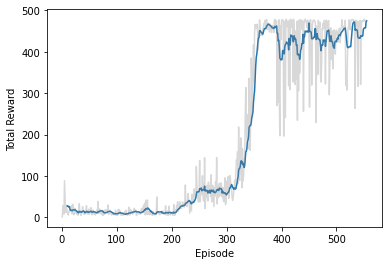

In [10]:
eps, rews = np.array(rewards_list).T
smoothed_rews = running_mean(rews, 10)
plt.plot(eps[-len(smoothed_rews):], smoothed_rews)
plt.plot(eps, rews, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total Reward')

## Watch a trained agent
Note that the episode ends after 500 steps.

In [11]:
def watch_agent(n_episodes):
    with tf.Session() as sess:
        saver.restore(sess, "checkpoints/cartpole.ckpt")
        for episode in range(n_episodes):
            state = env.reset()
            r = 0
            while True:
                r += 1
                feed = {mainQN.inputs_: state.reshape((1, *state.shape))}
                Qs = sess.run(mainQN.output, feed_dict=feed)
                action = np.argmax(Qs)
                state, reward, done, _ = env.step(action)
                env.render()
                sleep(0.05)
                # comment this if statement to see an endless episode
                if done:
                    env.close()
                    print(f"reward: {r}")
                    break

In [13]:
watch_agent(5)

INFO:tensorflow:Restoring parameters from checkpoints/cartpole.ckpt
reward: 500
reward: 500
reward: 500
reward: 500
reward: 500
